# ConvNet Architectures
The purpose of this lab is to teach to design your own ConvNets from scratch (and implement other people's architectures from research papers).

If you instead feel like catching up on transfer learning, you can revisit one of the following:
- [Lab2](https://github.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2024/blob/main/Lab2_FeatureExtractionAndTransferLearning.ipynb), Task 9 (Keras)
- [Lab 5 - Transfer learning](https://github.com/klaverhenrik/Deep-Learning-for-Visual-Recognition-2024/blob/main/Lab5_PyTorch_TransferLearning.ipynb) (PyTorch).

**Remember to enable GPU**

**NOTE:** In case you have trouble running Keras/TensorFlow in Colab, try one of the following:

In [ ]:
# Try this
#!pip install --upgrade tensorflow==1.8.0

# ... or this
#%tensorflow_version 1.x

# Check TensorFlow version
#import tensorflow as tf
#print(tf.__version__)

## 1. Download data and train simple ConvNet with Keras
First download the CIFAR10 dataset:

In [2]:
from __future__ import print_function
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
import numpy as np

num_classes = 10

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Subtract pixel mean (zero-center)
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


Set up simple ConvNet:

In [3]:
inputs = Input(shape=input_shape)

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 30, 30, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,514 (154.35 KB)

 Trainable params: 39,514 (154.35 KB)

 Non-trainable params: 0 (0.00 B)

... and train (while training you may want to read ahead on Task 1):

In [5]:
batch_size = 32
epochs = 4

# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Fit the model on the batches generated by datagen.flow().
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, shuffle=True)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step - accuracy: 0.2736 - loss: 1.9538 - val_accuracy: 0.4562 - val_loss: 1.4773
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.4112 - loss: 1.6138 - val_accuracy: 0.4828 - val_loss: 1.3929
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 28ms/step - accuracy: 0.4463 - loss: 1.5184 - val_accuracy: 0.5175 - val_loss: 1.3267
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 25ms/step - accuracy: 0.4687 - loss: 1.4707 - val_accuracy: 0.5404 - val_loss: 1.2588
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5464 - loss: 1.2540
Test loss: 1.2587850093841553
Test accuracy: 0.5404000282287598


Plot loss and accuracy curves

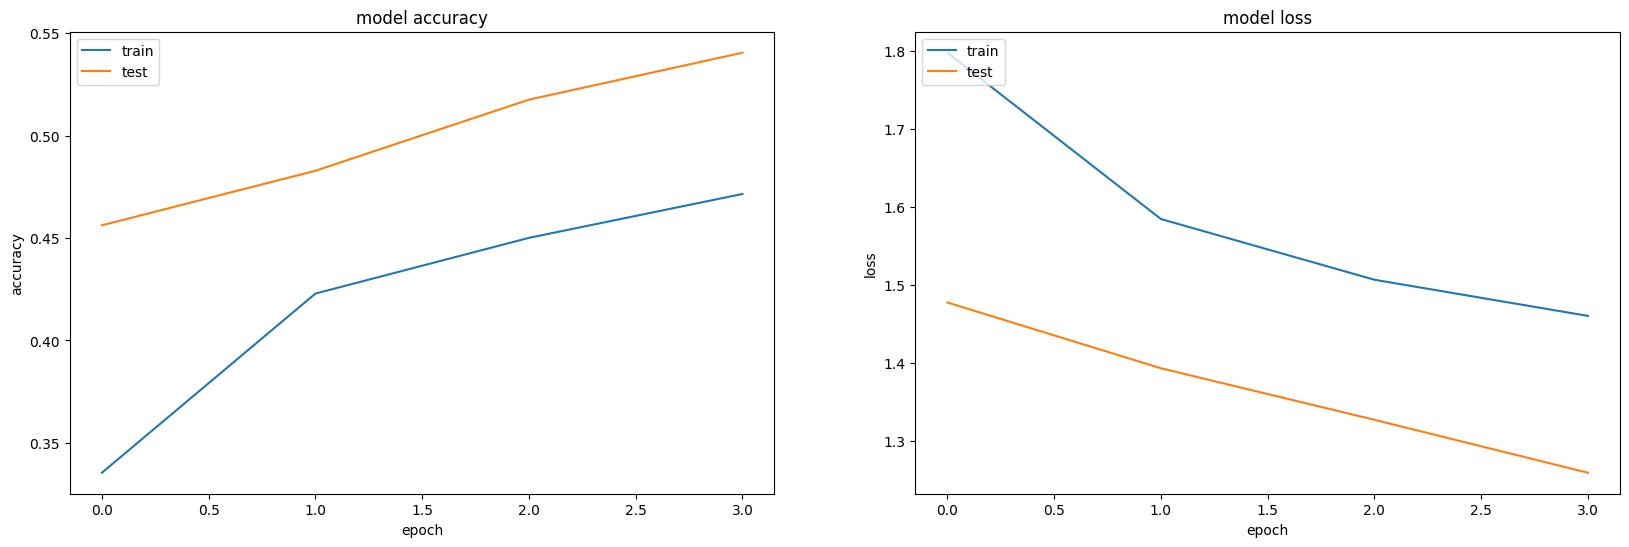

In [6]:
import matplotlib.pyplot as plt

def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

show_history(history)

###Bonus question (not related to today's topic):
- Has this network finished training? Why? Why not?

###Answer:
- Look at the loss curves. The training loss is still going down, which indicates that the model is not done training. On the other the validation loss seems to have stabilized, which could indicate that further training would result in overfitting (validation loss starts going up). In practise, I would run a few more iterations to see if I could get the validation loss a bit further down.

##2. Task 1: Write down the network architecture
The architecture of AlexNet (including output shapes) can be written in this format (see lecture 6 slides):

```
[227x227x3] INPUT
[55x55x96] CONV1: 96 11x11 filters at stride 4, pad 0
[27x27x96] MAX POOL1: 3x3 filters at stride 2
[27x27x96] NORM1: Normalization layer
[27x27x256] CONV2: 256 5x5 filters at stride 1, pad 2
[13x13x256] MAX POOL2: 3x3 filters at stride 2
[13x13x256] NORM2: Normalization layer
[13x13x384] CONV3: 384 3x3 filters at stride 1, pad 1
[13x13x384] CONV4: 384 3x3 filters at stride 1, pad 1
[13x13x256] CONV5: 256 3x3 filters at stride 1, pad 1
[6x6x256] MAX POOL3: 3x3 filters at stride 2
[4096] FC6: 4096 neurons
[4096] FC7: 4096 neurons
[1000] FC8: 1000 neurons (class scores)
```
where `[...]` denotets the output shape of the layer.

Using the same format, write down the architecture of the network you just trained (you also need to specify stride and pad):


```
[???] INPUT
[???]
...
```



In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          4640  

###Solution:

```
[32x32x3] INPUT
[30x30x8] CONV1: 8 3x3 filters at stride 1, pad 0
[15x15x8] MAX POOL1: 2x2 filters at stride 2
[13x13x8] CONV2: 16 3x3 filters at stride 1, pad 0
[6x6x16] MAX POOL2: 2x2 filters at stride 2
[4x4x32] CONV3: 32 3x3 filters at stride 1, pad 0
[64] FC1: 64 neurons
[10] FC2: 10 neurons (class scores)
```

##3. Task 2: Implement simple network architectures
###Task 2.1 Padding for preserving shape
Padding (or zero-padding) is mostly used when we want the output of a convolution layer to have the same shape is the input.

Keras' Conv2D layer does not allow you to specify the padding directly (as an integer). Rather you can chose between `'valid'` and `'same'`. Check the [documentation](https://keras.io/api/layers/convolution_layers/convolution2d/) to see what the difference is. By changing the padding only, modify our model to have the following architecture.

Also fill in the `???` (i.e., what is the pad size?):
```
[32x32x3] INPUT
[32x32x8] CONV1: 8 3x3 filters at stride 1, pad 1
[16x16x8] MAX POOL1: 2x2 filters at stride 2
[16x16x16] CONV2: 16 3x3 filters at stride 1, pad 1
[8x8x16] MAX POOL2: 2x2 filters at stride 2
[8x8x32] CONV3: 32 3x3 filters at stride 1, pad 1
[64] FC1: 64 neurons
[10] FC2: 10 neurons (class scores)
```
Note that the shape is the same before and after each convolution layer.

In [7]:
# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 137,818 (538.35 KB)

 Trainable params: 137,818 (538.35 KB)

 Non-trainable params: 0 (0.00 B)

**Note:** It is possible to exactly control zero-padding Keras. See [ZeroPadding2D](https://keras.io/api/layers/reshaping_layers/zero_padding2d/).

###Task 2.2 Stride for downsampling
As mentioned in Lecture 4, *max pool* for downsampling is more or less deprecated. Instead, modern network architectures use `stride > 1` in the convolutiton layers for downsampling.

Change the stride of the convolution layers to implement the following architecture.

Also fill in the `???` (i.e., what is the stride and pad size?):
```
[32x32x3] INPUT
[16x16x8] CONV1: 8 3x3 filters at stride 2, pad 1
[8x8x16] CONV2: 16 3x3 filters at stride 2, pad 1
[4x4x32] CONV3: 32 3x3 filters at stride 2, pad 1
[64] FC1: 64 neurons
[10] FC2: 10 neurons (class scores)
```

###Solution:

In [8]:
# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = Conv2D(16, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,514 (154.35 KB)

 Trainable params: 39,514 (154.35 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, shuffle=True)

Epoch 1/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 29ms/step - accuracy: 0.2765 - loss: 1.9649 - val_accuracy: 0.4656 - val_loss: 1.4894
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/step - accuracy: 0.4091 - loss: 1.6259 - val_accuracy: 0.4980 - val_loss: 1.3889
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.4434 - loss: 1.5338 - val_accuracy: 0.5158 - val_loss: 1.3381
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.4654 - loss: 1.4787 - val_accuracy: 0.5270 - val_loss: 1.2966


###Task 2.3: Batch normalization
Always use batch normalization! It reduces the risk of vanishing gradients (i.e., it ensures that we have gradient flow through the whole network) and makes training faster.

Batch normalization is performed after convolution, but before activation.

To implement the architecture below you will need to separate the ReLU from the convolution layer. That is, instead of

```
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
```

write

```
x = Conv2D(16, kernel_size=(3, 3))(x)
x = Activation('relu')(x)
```

Required documentation:
- https://keras.io/activations/
- https://keras.io/layers/normalization/

Your task is to implement this architecture, where I have written out batch normalization (BN) and ReLU activation explicitly:

```
[32x32x3] INPUT
[16x16x8] CONV1: 8 3x3 filters at stride 2, pad 1
[16x16x8] BN1: Batch normalization
[16x16x8] ReLU
[8x8x16] CONV2: 16 3x3 filters at stride 2, pad 1
[8x8x16] BN2: Batch normalization
[8x8x16] ReLU
[4x4x32] CONV3: 32 3x3 filters at stride 2, pad 1
[4x4x32] BN3: Batch normalization
[4x4x32] ReLU
[64] FC1: 64 neurons
[10] FC2: 10 neurons (class scores)
```

###Solution:

In [10]:
from tensorflow.keras.layers import BatchNormalization, Activation

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(16, kernel_size=(3, 3), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,738 (155.23 KB)

 Trainable params: 39,626 (154.79 KB)

 Non-trainable params: 112 (448.00 B)

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, shuffle=True)

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 30ms/step - accuracy: 0.2583 - loss: 2.0203 - val_accuracy: 0.4423 - val_loss: 1.5284
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.3967 - loss: 1.6433 - val_accuracy: 0.4968 - val_loss: 1.3857
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.4425 - loss: 1.5339 - val_accuracy: 0.5107 - val_loss: 1.3440
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.4625 - loss: 1.4896 - val_accuracy: 0.5493 - val_loss: 1.2345


###Task 2.4: Global average pooling
Recall that global average pooling takes an NxNxC volume and reduces it to a C-dimensional vector by averaging the NxN valus of each channel (c).

Thus, we can replace the `Flatten` layer and the first `Dense` layer (i.e., fully connected layer) with a global average pooling layer.

Check the documentation here:
https://keras.io/api/layers/pooling_layers/global_average_pooling2d/

Your task is to implement the following architecture:

```
[32x32x3] INPUT
[16x16x8] CONV1: 8 3x3 filters at stride 2, pad 1
[8x8x16] CONV2: 16 3x3 filters at stride 2, pad 1
[4x4x32] CONV3: 32 3x3 filters at stride 2, pad 1
[32] GAP: Global average pooling
[10] FC2: 10 neurons (class scores)
```

###Solution

In [12]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inputs)
x = Conv2D(16, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
x = GlobalAveragePooling2D()(x)

# Decoder (1 fully connected layer)
predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 16, 16, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 8, 8, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 4, 4, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,362 (24.85 KB)

 Trainable params: 6,362 (24.85 KB)

 Non-trainable params: 0 (0.00 B)

**Note** that because we removed a dense layer, the above model looses some of its original capacity, so it might perform worse on the validation set.

By inspecting the output of model.summary() you can see exactly how many trainable parameters the model has. Compare the number of parameters before and after replacing Flatten with GlobalAveragePooling2D.

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, shuffle=True)

Epoch 1/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 48s 28ms/step - accuracy: 0.2381 - loss: 2.0376 - val_accuracy: 0.3366 - val_loss: 1.7614
Epoch 2/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 25ms/step - accuracy: 0.3653 - loss: 1.7299 - val_accuracy: 0.4126 - val_loss: 1.6222
Epoch 3/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.3985 - loss: 1.6361 - val_accuracy: 0.4225 - val_loss: 1.5887
Epoch 4/4
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.4149 - loss: 1.5878 - val_accuracy: 0.4434 - val_loss: 1.5344


###Task 2.6: Variable input size
The really cool thing about global average pooling is that it allows the network to handle input images of variable size.

Consider the following piece of code (it's supposed to crash...):


In [15]:
# Tell Keras that height/width can be arbitrary
variable_input_shape = ((None,None,3))
variable_inputs = Input(variable_input_shape)

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(variable_inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)

ValueError: Shapes used to initialize variables must be fully-defined (no `None` dimensions). Received: shape=(None, 64) for variable path='dense_9/kernel'

What goes wrong is that the Flatten layer must know the shape of the input `x` in advance. Now, lets replace it with a global average pooling layer and see what happens:

In [22]:
# Tell Keras that height/width can be arbitrary
variable_input_shape = ((None,None,3))
variable_inputs = Input(variable_input_shape)

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(variable_inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
encoded = GlobalAveragePooling2D()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)
# This creates a callable model that includes the Input layer and the prediction layer

model = Model(inputs=variable_inputs, outputs=predictions)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, None, None, 8)       │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, None, None, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, None, None, 16)      │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, None, None, 16)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, None, None, 32)      │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,794 (34.35 KB)

 Trainable params: 8,794 (34.35 KB)

 Non-trainable params: 0 (0.00 B)

Now, we can run the network on images of arbitrary shape:

In [23]:
# Make a batch of images that have size 36x36 instead of 32x32
import cv2
batch = x_train[0:batch_size,:]
batch_resized = np.zeros((batch_size,36,36,3))
for i in range(batch_size):
  batch_resized[i,:,:,:] = cv2.resize(batch[i,:,:,:],(36,36))

# Shape 32x32
predictions = model.predict(batch)
print(predictions.shape)

# Shape 36x36
predictions = model.predict(batch_resized)
print(predictions.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
(32, 10)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
(32, 10)


####Question
There is a small caveat, however. The network can only handle input images down to a certain shape (height/width).
- Why?
- What is the smallest input width/height this model can handle?

###Answer
If you set the height/width to 18, it still works. The output shape of the last convolution layer becomes 1x1x32. If you set the height/width lower than 18, the calculated output dimensions of that layer become zero or negative. So 18 is the minimum height/width according to my experiments :-)

In [24]:
# Tell Keras that height/width can be arbitrary
variable_input_shape = ((18,18,3))
variable_inputs = Input(variable_input_shape)

# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), activation='relu')(variable_inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
encoded = GlobalAveragePooling2D()(x)

# Decoder (2 fully connected layers)
x = Dense(64, activation='relu')(encoded)
x = Dropout(0.5)(x)
predictions = Dense(num_classes,activation='softmax')(x)
# This creates a callable model that includes the Input layer and the prediction layer

model = Model(inputs=variable_inputs, outputs=predictions)
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 18, 18, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 16, 16, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 8, 8, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 6, 6, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 3, 3, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 1, 1, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,794 (34.35 KB)

 Trainable params: 8,794 (34.35 KB)

 Non-trainable params: 0 (0.00 B)

##Task 3: Implement building blocks of advanced network architectures
###Task 3.1 Naive Inception module
The simple, naive inception module combines 1x1, 3x3, and 5x5 convolution, as well as max pooling, into a single *layer* or *module*. It does so by concatenating along the channel dimension.

Suppose the input to the module (called `x`) has shape `NxNxC`. Then the outputs of the convolutions should be:

- `NxNxf1` for `conv1` (1x1 convolution), where `f1` is the number of 1x1 filters.
- `NxNxf3` for `conv3` (3x3 convolution), where `f3` is the number of 3x3 filters.
- `NxNxf5` for `conv5` (5x5 convolution), where `f5` is the number of 5x5 filters.

and the output of the max pooling layer should be

- `NxNxC` for `pool` (3x3 max pooling)

You can then use Keras' `Concatenate`layer to combine the outputs. The shape of the output should be `NxNx(f1+f3+f5+C)`.

Below is a template for implementing and testing a naive inception module. Your task is to fill in the empty gaps. The output should look like this:

![alt text](https://github.com/aivclab/dlcourse/blob/master/data/inception_naive.png?raw=true)

**NOTE 1** that the `InputLayer` is *not* part of the inception module, and neither is the first `Conv2D` layer. The first `Conv2D` layer just serves to generate an input feature map with a "nice" shape, meaning that the dimensions are powers of 2 (in this case `16x16x64`).

If you need to consult the documentation, it is here: [Conv2d](https://keras.io/api/layers/convolution_layers/convolution2d/) [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/).


In [ ]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import plot_model

# Naive inception module
def naive_inception_module(x, f1=64, f3=128, f5=32):
  # 1x1 conv
  conv1 = Conv2D(filters=???, kernel_size=???, padding=???, activation='relu')(x)
  # 3x3 conv
  conv3 = Conv2D(filters=???, kernel_size=???, padding=???, activation='relu')(x)
  # 5x5 conv
  conv5 = Conv2D(filters=???, kernel_size=???, padding=???, activation='relu')(x)
  # 3x3 max pooling
  pool = MaxPooling2D(pool_size=(3,3), strides=???, padding=???)(x)
  # concatenate filters, assumes filters/channels last
  y = Concatenate()([conv1, conv3, conv5, pool])

  return y

# Prior convolution(s) - not part of the inception module:
# - inputs has shape 32x32x3
# - x has shape 16x16x64 and serves as input to the inception module
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same',activation='relu')(inputs)

# Add inception block 1
layer = naive_inception_module(x)

# create model
model = Model(inputs=inputs, outputs=layer)
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='inception_module.png')

###Solution:

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 16, 16, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 16, 16, 64)     │          4,160 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 16, 16, 128)    │         73,856 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 16, 16, 32)     │         51,232 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_14          │ (None, 16, 16, 64)     │              0 │ conv2d_30[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 288)    │              0 │ conv2d_31[0][0],       │
│                           │                        │                │ conv2d_32[0][0],       │
│                           │                        │                │ conv2d_33[0][0],       │
│                           │                        │                │ max_pooling2d_14[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 131,040 (511.88 KB)

 Trainable params: 131,040 (511.88 KB)

 Non-trainable params: 0 (0.00 B)

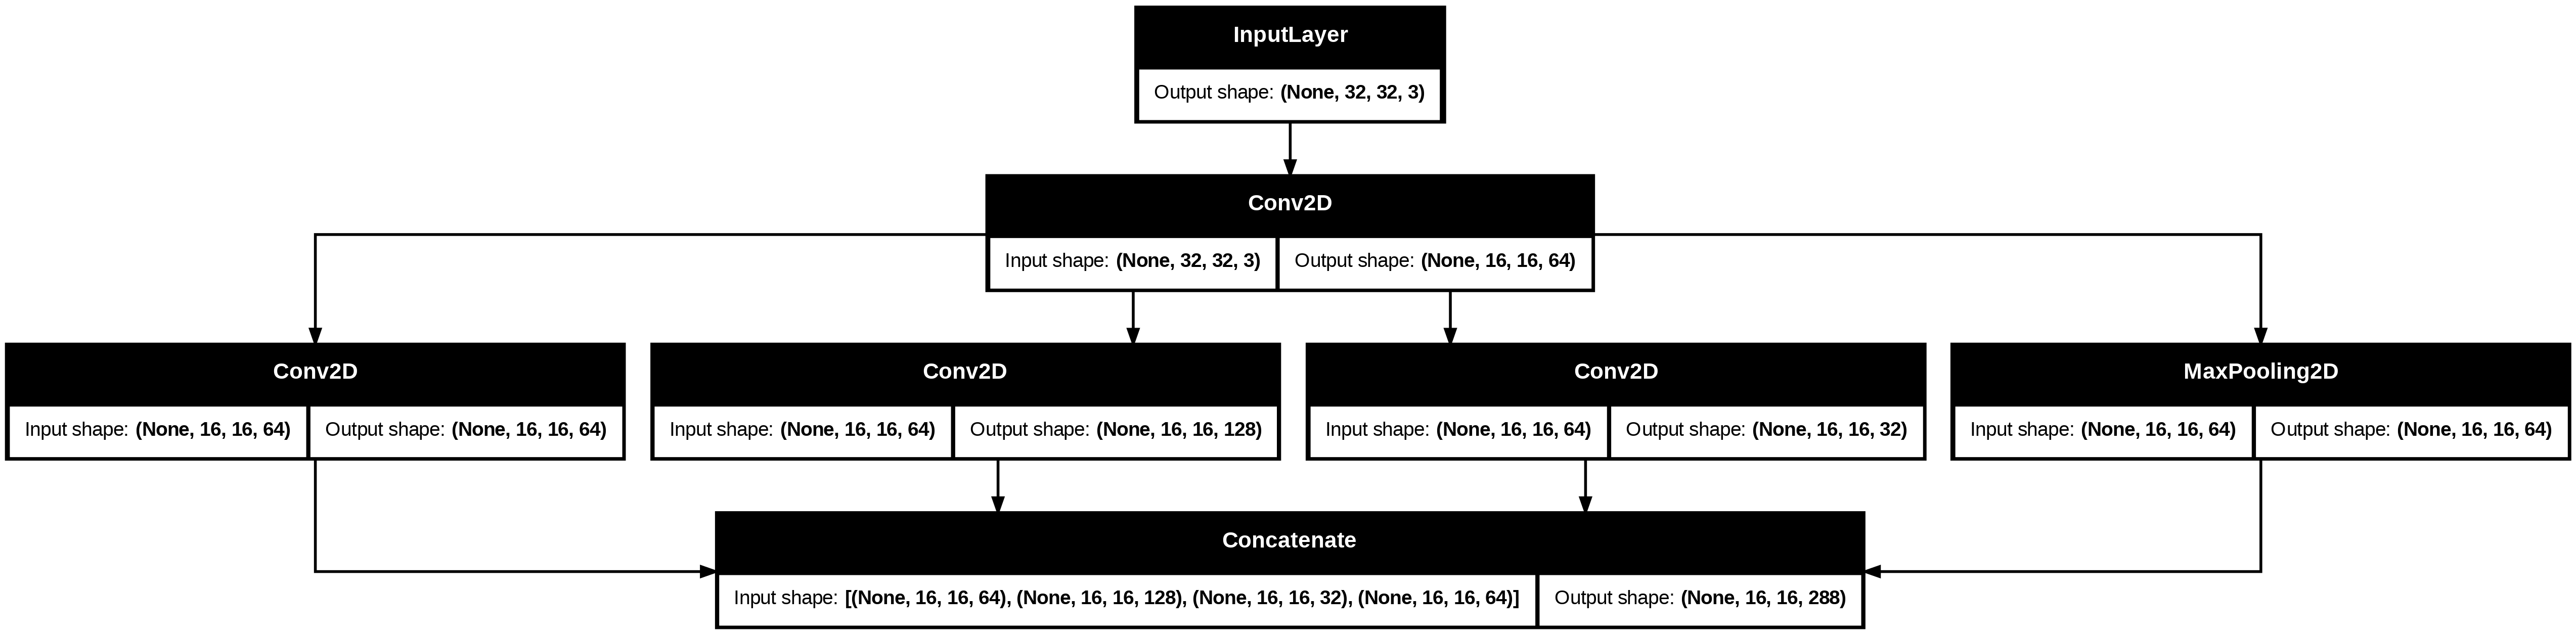

In [26]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import plot_model

def naive_inception_module(x, f1=64, f3=128, f5=32):
  # 1x1 conv
  conv1 = Conv2D(filters=f1, kernel_size=(1,1), padding='same', activation='relu')(x)
  # 3x3 conv
  conv3 = Conv2D(filters=f3, kernel_size=(3,3), padding='same', activation='relu')(x)
  # 5x5 conv
  conv5 = Conv2D(filters=f5, kernel_size=(5,5), padding='same', activation='relu')(x)
  # 3x3 max pooling
  pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(x)
  # concatenate filters, assumes filters/channels last
  y = Concatenate()([conv1, conv3, conv5, pool])
  return y

# Prior convolution(s) - not part of the inception module:
# - inputs has shape 32x32x3
# - x has shape 16x16x64 and serves as input to the inception module
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same',activation='relu')(inputs)

# Add inception block 1
layer = naive_inception_module(x)

# create model
model = Model(inputs=inputs, outputs=layer)
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='inception_module.png')

###Question:
- What is the number of trainable parameters in the simple model above?

###Answer:
- 131,040 according to the summary table

###Task 3.2 Inception module
The version of the inception module that we have implemented is called the *naive inception module*.

A modification to the module was made in order to reduce the amount of computation required. Specifically, 1×1 convolutional layers were added to reduce the number of filters before the 3×3 and 5×5 convolutional layers, and to decrease the number of channels after the pooling layer.

1×1 convolutions are used to compute reductions **before** the expensive 3×3 and 5×5 convolutions. Besides being used as reductions, they also include the use of rectified linear activation making them dual-purpose. In addition, a 1x1 convolution is added **after** the max pooling layer to reduce dimensionality.

Suppose the input to the module (called `x`) has shape `NxNxC`. Then the outputs of the convolutions should be:

- `NxNxf1` for `conv1` (1x1 convolution), where `f1` is the number of 1x1 filters.
- `NxNxf3_reduce` for `conv3_reduce` (1x1 convolution), where `f3_reduce` is the number of 1x1 filters.
- `NxNxf3` for `conv3` (3x3 convolution), where `f3` is the number of 3x3 filters. Note that the input to `conv3` is not `x`, but `conv3_reduce`.
- `NxNxf5_reduce` for `conv5_reduce` (1x1 convolution), where `f5_reduce` is the number of 1x1 filters.
- `NxNxf5` for `conv5` (5x5 convolution), where `f5` is the number of 5x5 filters. Note that the input to `conv5` is not `x`, but `conv5_reduce`.

and the output of the max pooling layer should be

- `NxNxC` for `pool` (3x3 max pooling)
- `NxNxfpool_reduce` for `pool_reduce` (1x1 convolution), where `fpool_reduce` is the number of 1x1 filters. Note that the input to `pool_reduce` is not `x`, but `pool`.

Below is a template for implementing and testing an inception module. Your task is to fill in the empty gaps. The output should look like this:

![alt text](https://github.com/aivclab/dlcourse/blob/master/data/inception.png?raw=true)

In [ ]:
def inception_module(x, f1=64, f3=128, f5=32, f3_reduce=32, f5_reduce=32, fpool_reduce=32):
  # 1x1 conv
  conv1 = Conv2D(filters=???, kernel_size=???, padding=???, activation='relu')(x)
  # 3x3 conv
  conv3_reduce = Conv2D(filters=???, kernel_size=???, padding=???, activation='relu')(x)
  conv3 = Conv2D(filters=???, kernel_size=???, padding=???, activation='relu')(conv3_reduce)
  # 5x5 conv
  conv5_reduce = Conv2D(filters=???, kernel_size=???, padding=???, activation='relu')(x)
  conv5 = Conv2D(filters=???, kernel_size=???, padding=???, activation='relu')(conv5_reduce)
  # 3x3 max pooling
  pool = MaxPooling2D(pool_size=(3,3), strides=???, padding='same')(x)
  pool_reduce = Conv2D(filters=???, kernel_size=???, padding='same', activation='relu')(pool)
  # concatenate filters, assumes filters/channels last
  y = Concatenate()([conv1, conv3, conv5, pool_reduce])
  return y

# Prior convolution(s) - not part of the inception module
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same',activation='relu')(inputs)

# Add inception block
layer = inception_module(x)

# create model
model = Model(inputs=inputs, outputs=layer)
model.summary()

# plot model architecture
plot_model(model, show_shapes=True)

###Question:
- What is the number of trainable parameters in the model above?
- What is the shape of the output? Compare to *naive* inception module.

###Answers:
- 74,816 according to the summary table below
- It is `16x16x256` vs `16x16x228` for the *naive* inception module. The reduction in number of channels comes from the 1x1x convolution performed after the max pooling layer.

###Solution:

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 16, 16, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 16, 16, 32)     │          2,080 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 16, 16, 32)     │          2,080 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_15          │ (None, 16, 16, 64)     │              0 │ conv2d_34[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 16, 16, 64)     │          4,160 │ conv2d_34[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 16, 16, 128)    │         36,992 │ conv2d_36[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 16, 16, 32)     │         25,632 │ conv2d_38[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 16, 16, 32)     │          2,080 │ max_pooling2d_15[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 16, 16, 256)    │              0 │ conv2d_35[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_37[0][0],       │
│                           │                        │                │ conv2d_39[0][0],       │
│                           │                        │                │ conv2d_40[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 74,816 (292.25 KB)

 Trainable params: 74,816 (292.25 KB)

 Non-trainable params: 0 (0.00 B)

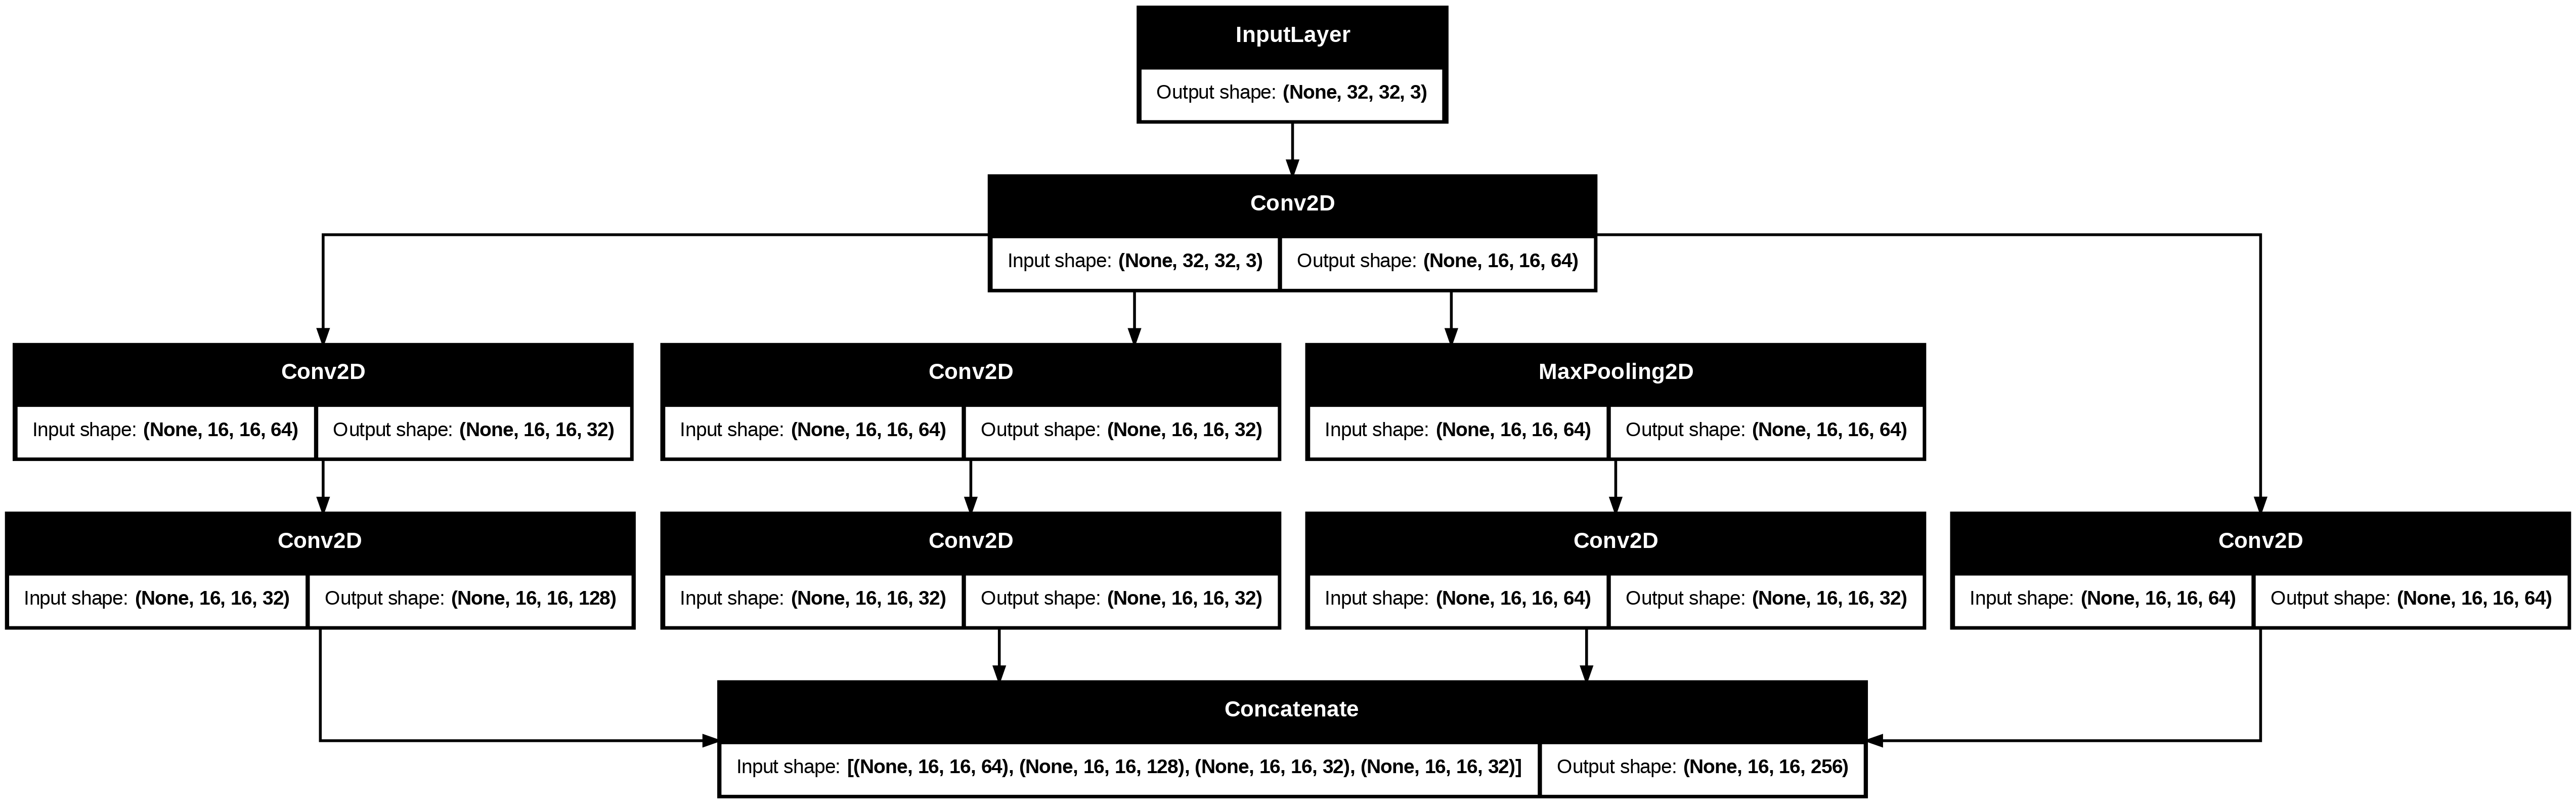

In [27]:
def inception_module(x, f1=64, f3=128, f5=32, f3_reduce=32, f5_reduce=32, fpool_reduce=32):
  # 1x1 conv
  conv1 = Conv2D(filters=f1, kernel_size=(1,1), padding='same', activation='relu')(x)
  # 3x3 conv
  conv3_reduce = Conv2D(filters=f3_reduce, kernel_size=(1,1), padding='same', activation='relu')(x)
  conv3 = Conv2D(filters=f3, kernel_size=(3,3), padding='same', activation='relu')(conv3_reduce)
  # 5x5 conv
  conv5_reduce = Conv2D(filters=f5_reduce, kernel_size=(1,1), padding='same', activation='relu')(x)
  conv5 = Conv2D(filters=f5, kernel_size=(5,5), padding='same', activation='relu')(conv5_reduce)
  # 3x3 max pooling
  pool = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(x)
  pool_reduce = Conv2D(filters=fpool_reduce, kernel_size=(1,1), padding='same', activation='relu')(pool)
  # concatenate filters, assumes filters/channels last
  y = Concatenate()([conv1, conv3, conv5, pool_reduce])
  return y

# Prior convolution(s) - not part of the inception module
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same',activation='relu')(inputs)

# Add inception block
layer = inception_module(x)

# create model
model = Model(inputs=inputs, outputs=layer)
model.summary()

# plot model architecture
plot_model(model, show_shapes=True)

###Task 3.3 ResNet block
A key innovation in the ResNet paper was the residual block. The residual block, specifically the identity residual model, is a block of two convolutional layers with the same number of filters and a small filter size, where the output of the second layer is added with the input to the first convolutional layer. Drawn as a graph, the input to the module is added to the output of the module and is called a shortcut connection:

We can implement this directly in Keras using the functional API and the add() merge function:

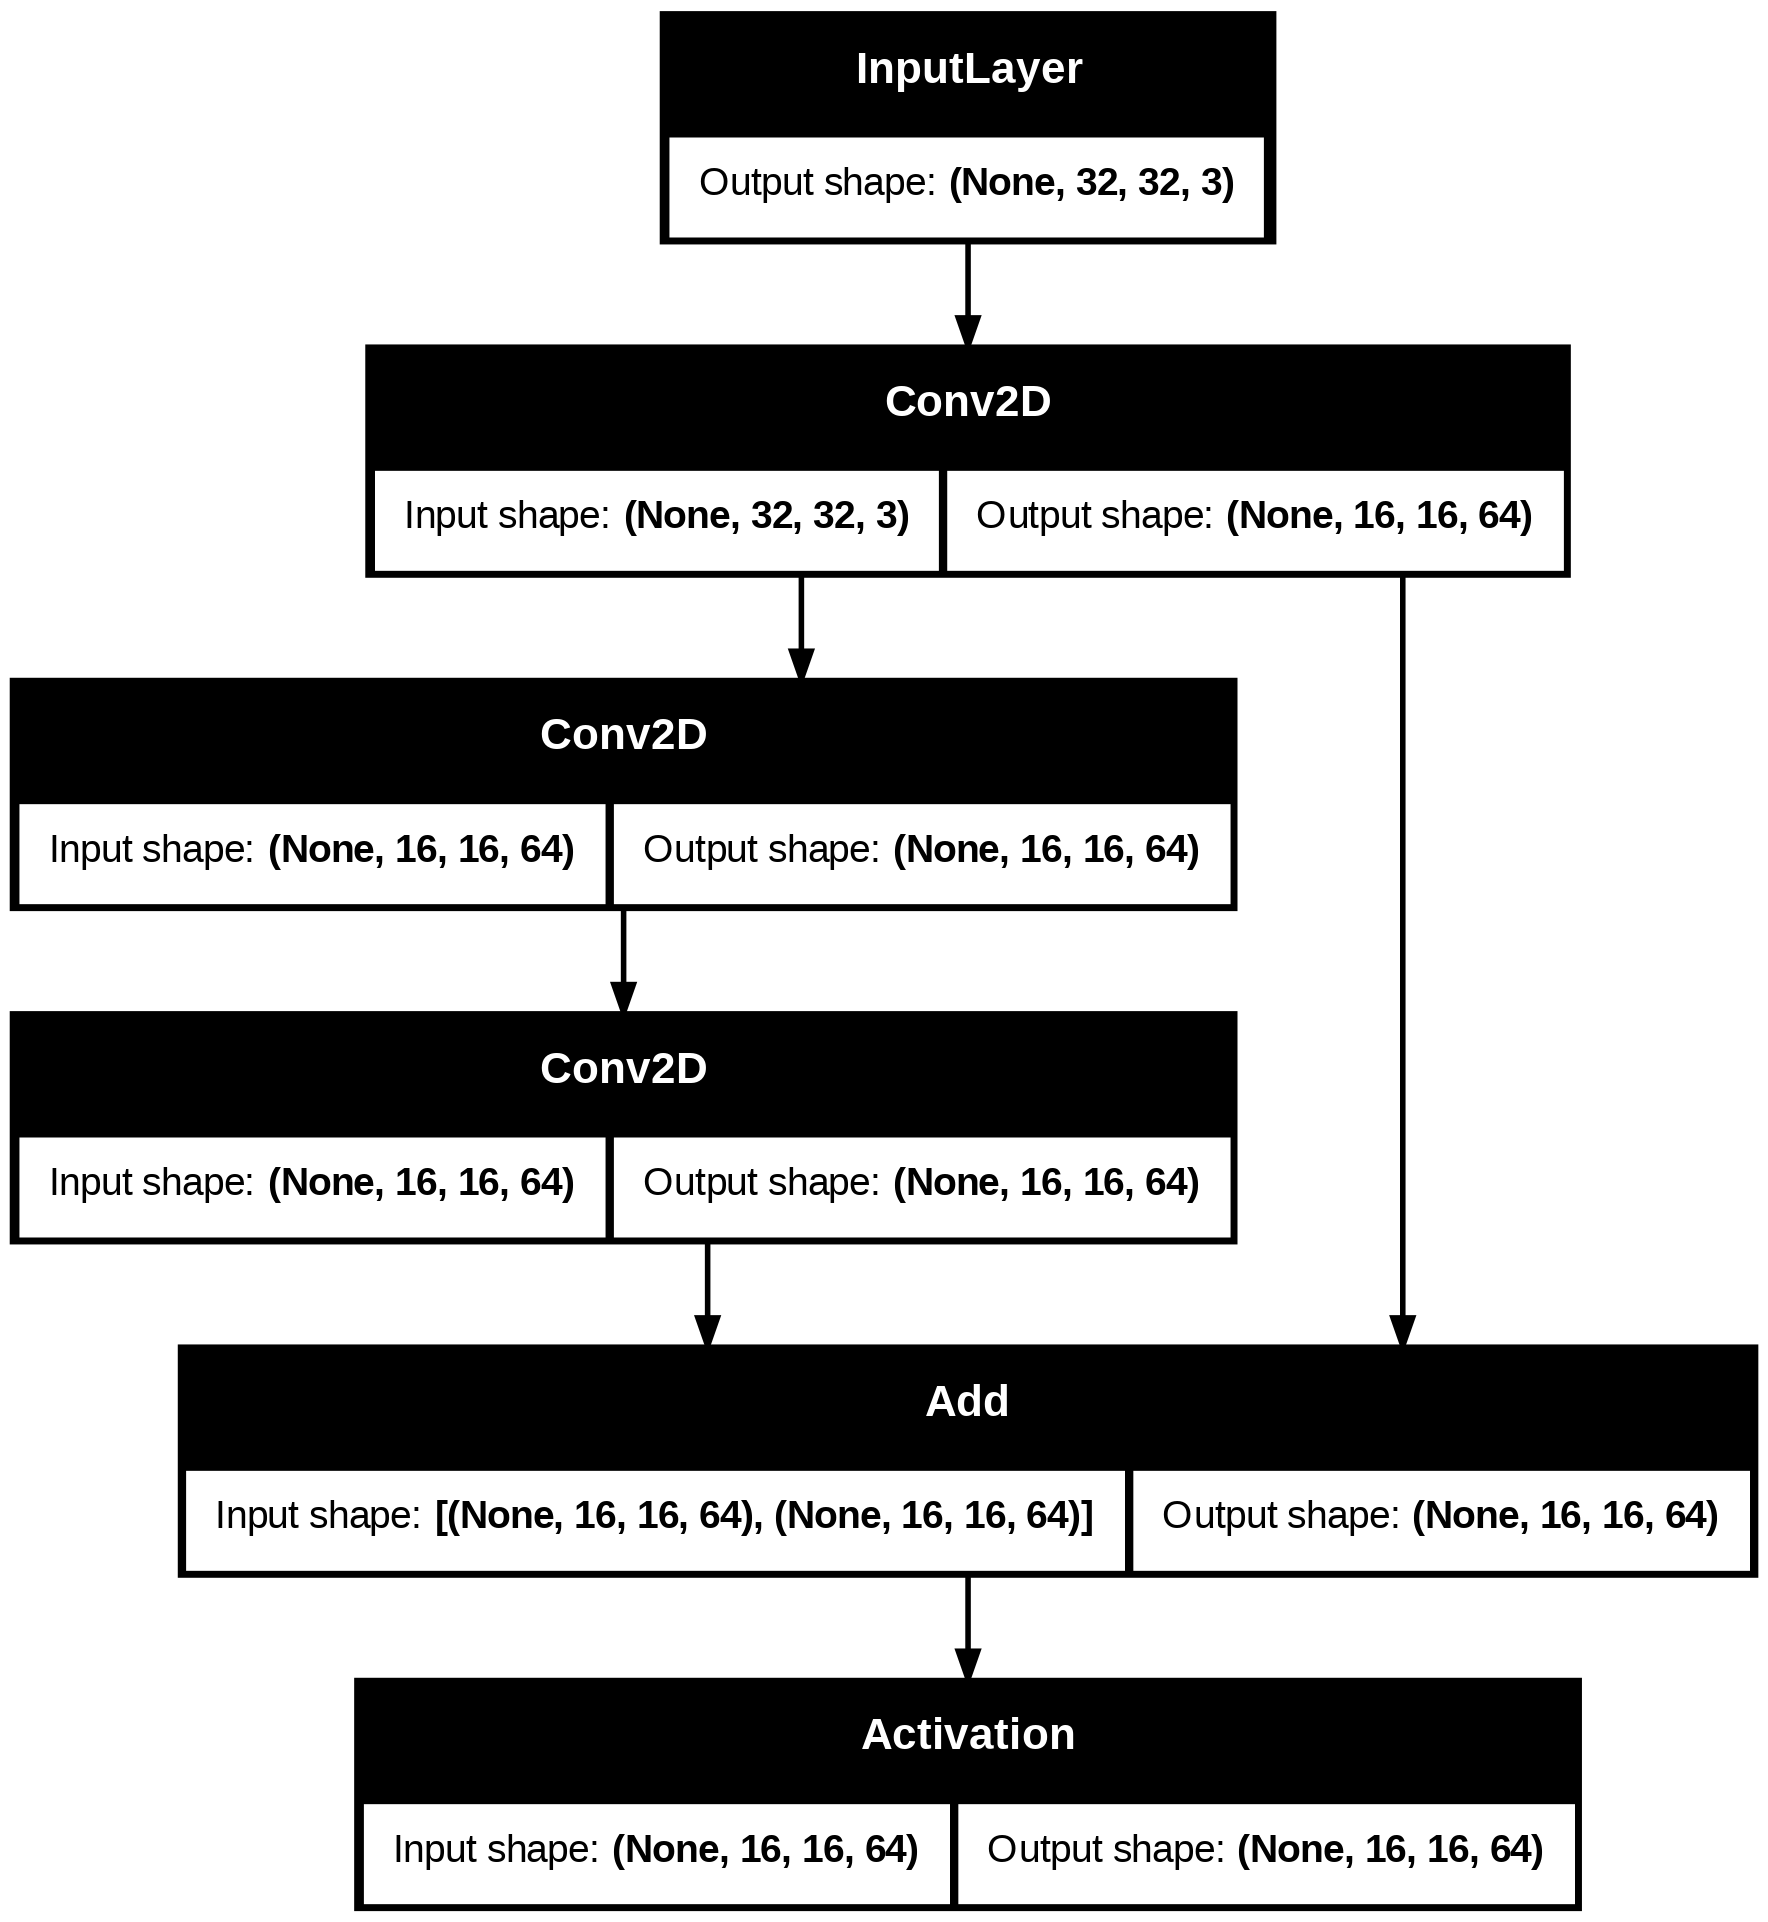

In [28]:
from tensorflow.keras.layers import Add

def residual_module_type1(x, f=64):
	# conv1
	conv1 = Conv2D(f, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
	# conv2
	conv2 = Conv2D(f, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	y = Add()([conv2, x])
	# activation function
	y = Activation('relu')(y)
	return y

# Prior convolution(s) - not part of the inception module
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same',activation='relu')(inputs)

# Add inception block
layer = residual_module_type1(x)

# create model
model = Model(inputs=inputs, outputs=layer)

# plot model architecture
plot_model(model, show_shapes=True)

The **Type 1** block above assumes that input `x` and output `y` have exactly the same shape. If this is not the case, we will get an error.

The **Type 2** block serves to
- downsample the input by a factor of two (along height and width dimensions)
- double the number of channels

Thus, if the input shape is `x.shape = N x N x C`, the output shape is `y.shape = N/2 x N/2 x C*2`.

In the top figure below, the solid skip connections mark Type 1 blocks (shape preserved), and dashed skip connections mark Type 2 blocks (height/width halfed and channels doubled):

![alt text](https://miro.medium.com/max/1372/1*6hF97Upuqg_LdsqWY6n_wg.png)

One solution to implementing a Type 2 block is as follows:
- `conv1`: Apply convolution on input `x` with a stride of 2 and `padding=same`. This has the effect of reducing the height and width by a factor of 2.
- `conv2`: Apply convolution on output of `conv1` with a stride of 1 to preserve height/width.
- `x_reshape`: This is the shortcut connection that must assure that `x` is reshaped to half the width/height. This can be done by applying a 1×1 convolution with a stride of 2 (before the addition).

Your task is to fill in the blanks here:

###Solution:

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_44 (Conv2D)        │ (None, 16, 16, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 8, 8, 128)      │         73,856 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 8, 8, 128)      │        147,584 │ conv2d_45[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 8, 8, 128)      │          8,320 │ conv2d_44[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 8, 8, 128)      │              0 │ conv2d_46[0][0],       │
│                           │                        │                │ conv2d_47[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 8, 8, 128)      │              0 │ add_1[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 231,552 (904.50 KB)

 Trainable params: 231,552 (904.50 KB)

 Non-trainable params: 0 (0.00 B)

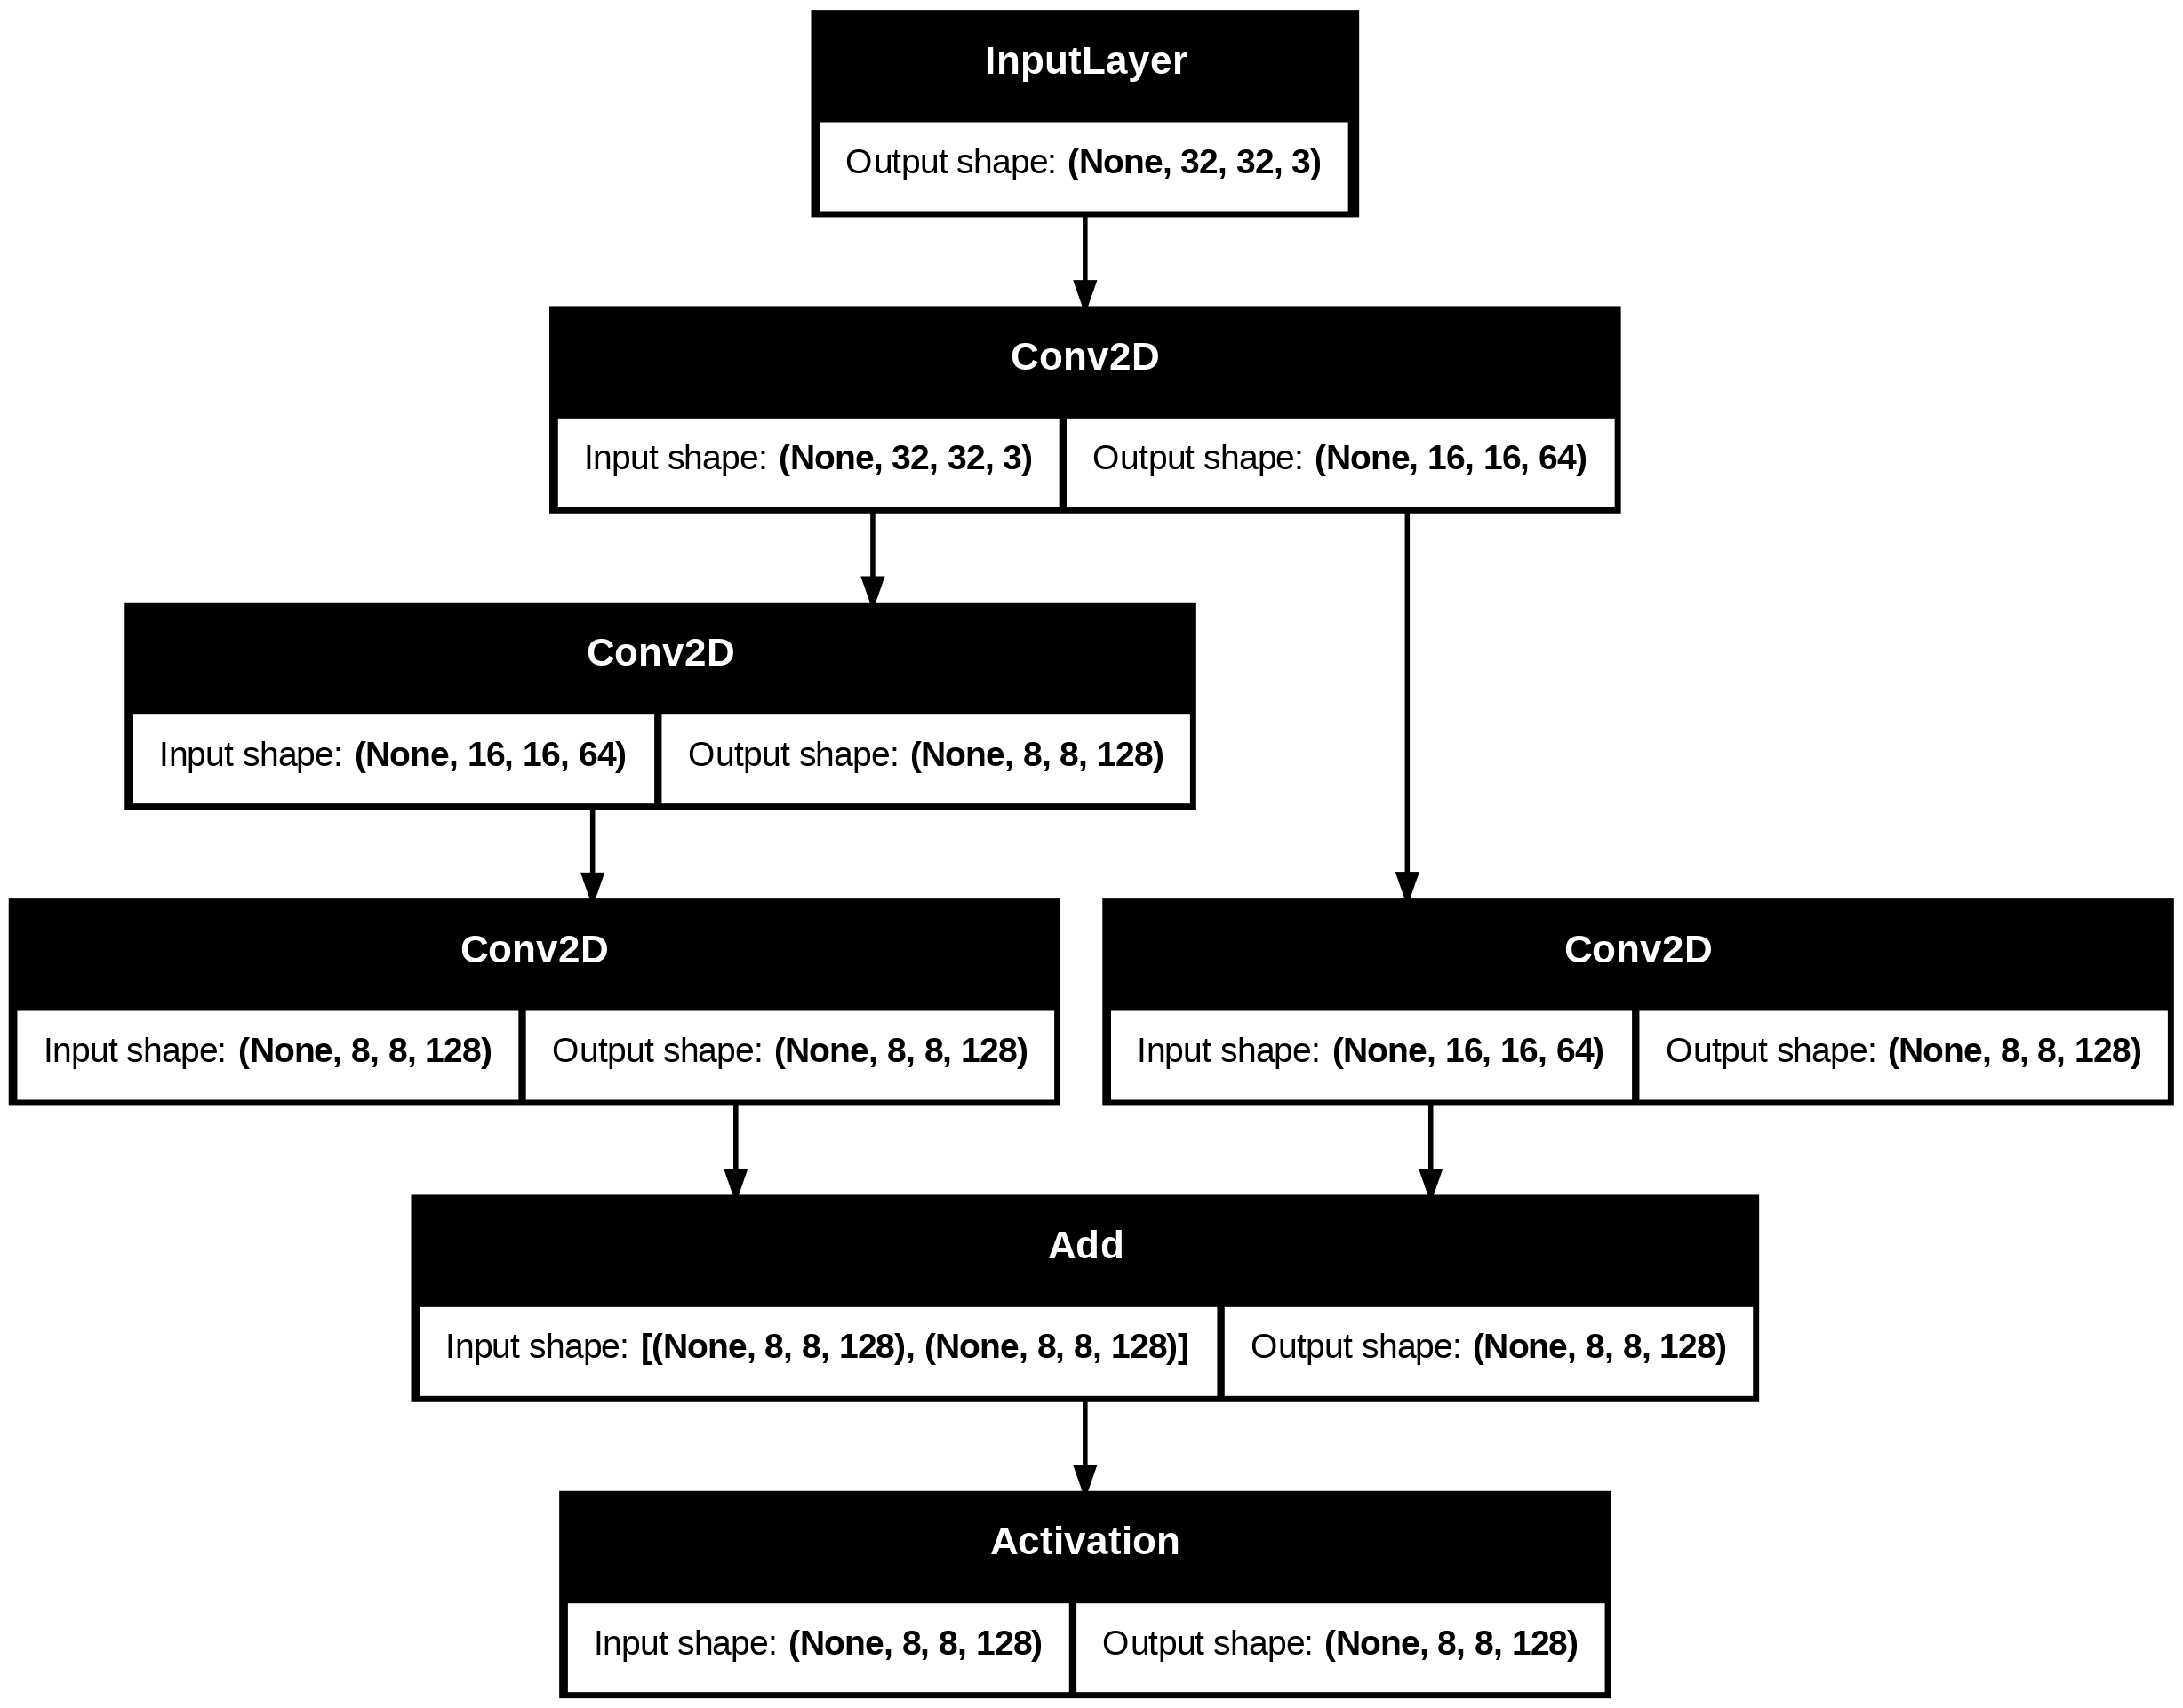

In [29]:
def residual_module_type2(x, f=64):
	# conv1 (reduces height/width by a factor of two and doubles the number of filters)
	conv1 = Conv2D(filters=2*f, kernel_size=(3,3), strides=2, padding='same', activation='relu', kernel_initializer='he_normal')(x)
	# conv2
	conv2 = Conv2D(filters=2*f, kernel_size=(3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
  # reshape x (downsample x by factor 2 and double number of filters)
	x_reshape = Conv2D(filters=2*f,kernel_size=(1,1), strides=2, padding='same',activation='linear')(x)
	# add filters, assumes filters/channels last
	y = Add()([conv2, x_reshape])
	# activation function
	y = Activation('relu')(y)
	return y

# Prior convolution(s) - not part of the residual module
x = Conv2D(64, kernel_size=(3, 3), strides=2, padding='same',activation='relu')(inputs)

# Add residual module
layer = residual_module_type2(x)

# create model
model = Model(inputs=inputs, outputs=layer)
model.summary()

# plot model architecture
plot_model(model, show_shapes=True)

###Task 3.4 Depthwise Separable Convolution
Depthwise separable convolution is a depthwise convolution followed by a
pointwise convolution as follows:

- **Depthwise convolution** is the channel-wise `K × K` spatial convolution. Suppose we have 64 channels, then we will have 64 `K × K` spatial convolutions. In Keras this is implemented using [DepthwiseConv2D](https://keras.io/api/layers/convolution_layers/depthwise_convolution2d/).
- **Pointwise convolution** actually is the `1 × 1` convolution to change the dimension to, say 256.

Your task is to convert the second convolution below

```
x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
```

to a depthwis separable convolution. The filter size is `K=3`, the input shape is `30x30x64` and the output shape should be `28x28x256`.

In [30]:
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
x = Conv2D(256, kernel_size=(3, 3), activation='relu')(x)
model = Model(inputs=inputs, outputs=x)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 28, 28, 256)         │         147,712 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 149,504 (584.00 KB)

 Trainable params: 149,504 (584.00 KB)

 Non-trainable params: 0 (0.00 B)

###Solution:

In [32]:
from tensorflow.keras.layers import DepthwiseConv2D

x = Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
x = DepthwiseConv2D(kernel_size=(3, 3), activation='relu')(x)
x = Conv2D(256,kernel_size=(1, 1), activation='relu')(x)
model = Model(inputs=inputs, outputs=x)
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 30, 30, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_1 (DepthwiseConv2D) │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 28, 28, 256)         │          16,640 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,072 (74.50 KB)

 Trainable params: 19,072 (74.50 KB)

 Non-trainable params: 0 (0.00 B)

###Questions
1. What is the number of parameters before and after converting to depthwise separate convolution (DSC)?
2. What is the operation cost with standard convolution vs. DSC (see slides Lecture 7)?

###Answers:
1. DSC has approximately 8 times fewer parameters, making it less prone to overfitting:
 - Before: 149,504
 - After: 19,072

2. Answers
- The operation cost for standard convolution is D_k x D_k x M x N x D_F x D_F, where
 - D_k = filter size = 3
 - M = number of input channels = 64
 - N = number of output channels = 256
 - D_F = output height/width = 28
 - Therefore cost = 115,605,504 operations

- The operation cost for DSC is D_k x D_k x M x D_F X D_F + M x N x D_F x D_F
 - Therefore cost = 451,584 + 12,845,056 = 13,296,640 operations (so approximately 9 times faster).